# Busbar Thermal Simulation

Adaptation from last year's version in Excel. Would prefer to do it in Python.

### Simulation Outline

See notes on *Accumulator - Splitter Box - V3.0 Busbar Design*

Set Parameters:

* Convective heat transfer coefficient: https://www.engineersedge.com/heat_transfer/convective_heat_transfer_coefficients__13378.htm

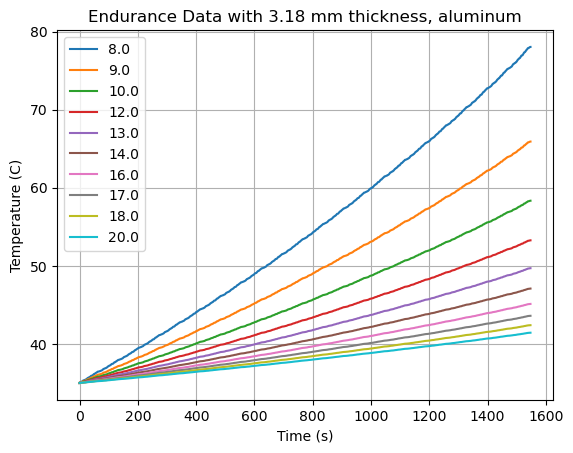

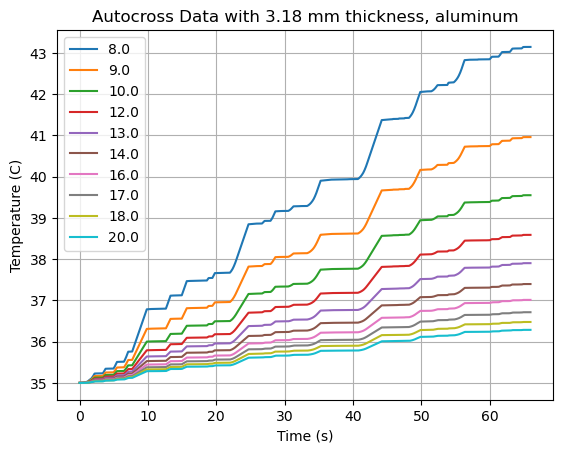

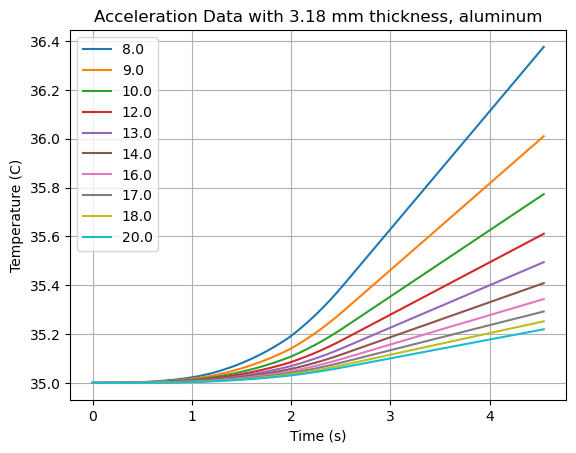

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

####### FILE PATHS
infile_endurance = 'dynamicsCalcs_endurance25.csv'
infile_autocross = 'dynamicsCalcs_auto80.csv'
infile_accel = 'dynamicsCalcs_accel80.csv'

outfile_endurance = "temp_endur25.csv"
outfile_autocross = 'temp_auto80.csv'
outfile_accel = 'temp_accel80.csv'

####### UPLOAD RELEVANT DATA FROM LAP SIM
endur_data = pd.read_csv(infile_endurance)
auto_data = pd.read_csv(infile_autocross)
accel_data = pd.read_csv(infile_accel)

####### SET UP PARAMETERS

### Aluminum
aluminum = {'rho_R': 2.82*10**(-8), 'rho_M': 2710, 'c': 900, 'alpha': 3.8e-3}

### Copper
copper = {'rho_R': 1.77*10**(-8), 'rho_M': 8960, 'c': 385, 'alpha': 3.93e-3}

# Choose material
material = {'aluminum': aluminum, 'copper': copper}

# Thermal Parameters:
T_ambient = 35                      # degrees C - ambient temp
h_free = 1                         # W/m2K - assumed convective heat transfer coefficient for free convection of air (minimum chosen)

# Geometry Parameters:
thickness = 3.18 * 10**(-3)         # m - busbar thickness - assumed 1/8"
length = 163.63 * 10**(-3)          # m - longest busbar length (splitter box, negative busbar)

####### VECTORIZED PARAMETER
# mat_choice = 'copper'
mat_choice = 'aluminum'

num = 10
width = np.linspace(8 * 10**(-3), 20 * 10**(-3), num)   # m - width options
A_x = width * thickness                                 # m2 - cross sectional area
A_s = 2 * thickness * length + 2 * width * length       # m2 - accessible surface area (ignore the 2x cross sectional area here)
mass = material[mat_choice]['rho_M'] * A_x * length     # kg - mass options
resistance = material[mat_choice]['rho_R'] * length / A_x # Ohms - resistance options
c = material[mat_choice]['c']                           # J/kgK - specific heat capacity
alpha = material[mat_choice]['alpha']                   # 1/C - Temperature coefficient

###########################################################################################
# Begin Simulation
# 1) Endurance, 2) Acceleration, 3) Autocross

def busbar_temp(dataDict, outfile, race, resistance):
    iterations = len(dataDict)
    busTemp = []                                                        # degrees C - List to record busbar temp
    Q_gen = []                                                          # W - List to record busbar heat generation
    Q_out = []                                                          # W - List to record heat out

    busTemp.append(T_ambient * np.ones(len(mass)))                      # First point required for temperature measurement

    for i in range(0, iterations - 1):
        delta_t = dataDict['t0'][i+1] - dataDict['t0'][i]                           # s - find the delta time
        Q_gen.append(dataDict['Pack Current'][i]**2 * resistance)                   # W - heat generated from busbar
        # Q_out.append(h_free * A_s * (busTemp[i] - T_ambient) / delta_t)           # W - heat out to air
        Q_out.append(np.zeros(len(mass)))                                           # W - to test adiabatic case (ie. coated wire)

        busTemp.append((Q_gen[i] - Q_out[i]) * delta_t / (mass * c) + busTemp[i])   # degrees C - next temperature point for busbar

        dR = resistance * alpha * (busTemp[i+1] - busTemp[i])                       # Calculate the new resistance values (delta R)
        resistance = resistance + dR                                                # Ohms - new resistance at new temperature

    # Save to a dataframe and then output to a .csv
    output_temp = pd.DataFrame(busTemp, columns=width)
    output_temp.to_csv(outfile)

    # Plot data
    plt.plot(dataDict['t0'], output_temp)
    plt.title((race + " Data with " + str(thickness * 1000) + " mm thickness, " + mat_choice))
    plt.grid(True)
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (C)")

    # scale width to mm for labels and then truncate
    width_scaled = np.trunc(width * 1000)
    plt.legend(width_scaled)
    plt.savefig(outfile.replace('csv', 'png'))
    plt.show()                                  # clear figure

    return output_temp

endur_temp = busbar_temp(endur_data, outfile_endurance, 'Endurance', resistance)
auto_temp = busbar_temp(auto_data, outfile_autocross, 'Autocross', resistance)
accel_temp = busbar_temp(accel_data, outfile_accel, 'Acceleration', resistance)

### Accumulator Bussing

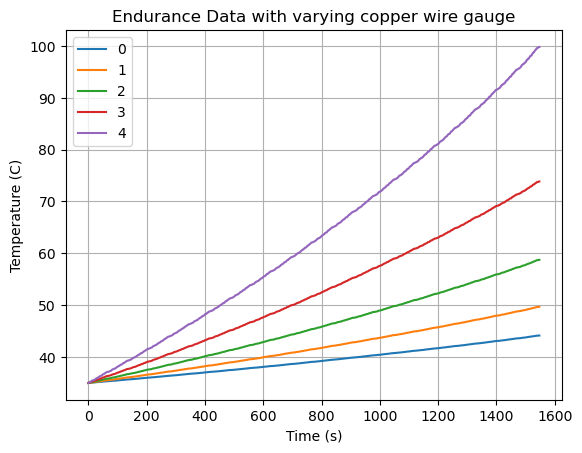

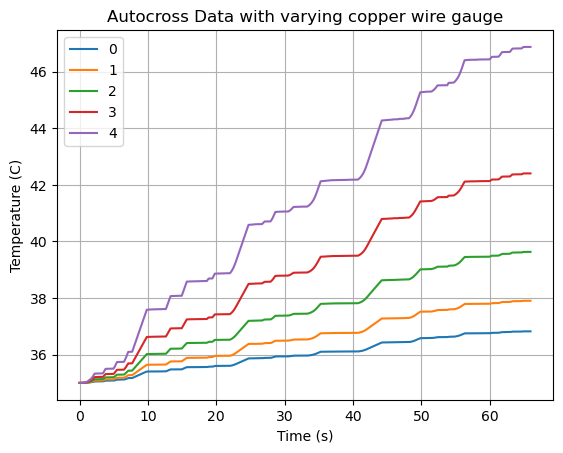

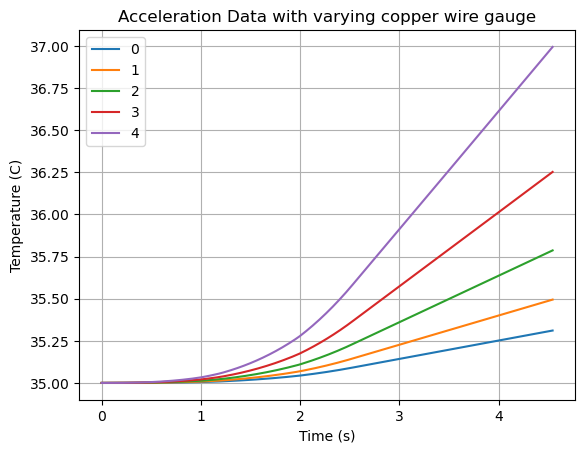

array([0, 1, 2, 3, 4])

In [14]:
%reset -f

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

####### FILE PATHS
infile_endurance = 'dynamicsCalcs_endurance25.csv'
infile_autocross = 'dynamicsCalcs_auto80.csv'
infile_accel = 'dynamicsCalcs_accel80.csv'

outfile_endurance = "temp_endur25_pack.csv"
outfile_autocross = 'temp_auto80_pack.csv'
outfile_accel = 'temp_accel80_pack.csv'

####### UPLOAD RELEVANT DATA FROM LAP SIM
endur_data = pd.read_csv(infile_endurance)
auto_data = pd.read_csv(infile_autocross)
accel_data = pd.read_csv(infile_accel)

####### SET UP PARAMETERS

### Aluminum
aluminum = {'rho_R': 2.82*10**(-8), 'rho_M': 2710, 'c': 900, 'alpha': 3.8e-3}

### Copper
copper = {'rho_R': 1.77*10**(-8), 'rho_M': 8960, 'c': 385, 'alpha': 3.93e-3}

# Choose material
material = {'aluminum': aluminum, 'copper': copper}

# Thermal Parameters:
T_ambient = 35                      # degrees C - ambient temp
h_free = 1                         # W/m2K - assumed convective heat transfer coefficient for free convection of air (minimum chosen)

# Geometry Parameters:
length = 0.8                        # m - longest busbar length (splitter box, negative busbar)

####### VECTORIZED PARAMETER
# mat_choice = 'copper'
mat_choice = 'aluminum'

pi = 3.1415
diameter = np.array([8.251, 7.348, 6.544, 5.827, 5.189]) * 10**(-3)  # m - diameter options
wire_gauges = np.arange(0, len(diameter))                           # wire gauge options
A_x = pi * diameter**2 / 4                              # m2 - cross sectional area
A_s = pi * diameter * length                            # m2 - accessible surface area (ignore the 2x cross sectional area here)
mass = material[mat_choice]['rho_M'] * A_x * length     # kg - mass options
resistance = material[mat_choice]['rho_R'] * length / A_x # Ohms - resistance options
c = material[mat_choice]['c']                           # J/kgK - specific heat capacity
alpha = material[mat_choice]['alpha']                   # 1/C - Temperature coefficient

###########################################################################################
# Begin Simulation
# 1) Endurance, 2) Acceleration, 3) Autocross

def busbar_temp(dataDict, outfile, race, resistance):
    iterations = len(dataDict)
    busTemp = []                                                        # degrees C - List to record busbar temp
    Q_gen = []                                                          # W - List to record busbar heat generation
    Q_out = []                                                          # W - List to record heat out

    busTemp.append(T_ambient * np.ones(len(mass)))                      # First point required for temperature measurement

    for i in range(0, iterations - 1):
        delta_t = dataDict['t0'][i+1] - dataDict['t0'][i]                           # s - find the delta time
        Q_gen.append(dataDict['Pack Current'][i]**2 * resistance)                   # W - heat generated from busbar
        # Q_out.append(h_free * A_s * (busTemp[i] - T_ambient) / delta_t)           # W - heat out to air
        Q_out.append(np.zeros(len(mass)))                                           # W - to test adiabatic case (ie. coated wire)

        busTemp.append((Q_gen[i] - Q_out[i]) * delta_t / (mass * c) + busTemp[i])   # degrees C - next temperature point for busbar

        dR = resistance * alpha * (busTemp[i+1] - busTemp[i])                       # Calculate the new resistance values (delta R)
        resistance = resistance + dR                                                # Ohms - new resistance at new temperature

    # Save to a dataframe and then output to a .csv
    output_temp = pd.DataFrame(busTemp, columns=diameter)
    output_temp.to_csv(outfile)

    # Plot data
    plt.plot(dataDict['t0'], output_temp)
    plt.title((race + " Data with varying copper wire gauge"))
    plt.grid(True)
    plt.xlabel("Time (s)")
    plt.ylabel("Temperature (C)")

    # scale diameter to mm for labels and then truncate
    # diameter_scaled = np.trunc(diameter * 1000)
    plt.legend(wire_gauges)
    plt.savefig(outfile.replace('csv', 'png'))
    plt.show()                                  # clear figure

    return output_temp

endur_temp = busbar_temp(endur_data, outfile_endurance, 'Endurance', resistance)
auto_temp = busbar_temp(auto_data, outfile_autocross, 'Autocross', resistance)
accel_temp = busbar_temp(accel_data, outfile_accel, 'Acceleration', resistance)

wire_gauges